<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Импортируем библиотеки, которые нам понадобятся для дальнейшей работы:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

Откроем наш датасет. Выведем на экран первые пять объектов, общую информацию о датасете и список характерных значений.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
pd.options.display.max_columns = None

display(df.head())
print('--------------------------------------------------')
df.info()
print('--------------------------------------------------')
df.describe()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
--------------------------------------------------


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Отсюда мы видим, что у нас имеется почти 27 тыс. объектов. Данные были собраны за период 01.03.2018 - 31.08.2018. В датасете представлено количетсво заказов такси за 10 мин. Также отмечаем, что минимальное количество заказов за 20 мин составило 0, а максимальное 119. В среднем за 10 мин такси заказаывали 14 раз.

Далее проверим наш временной ряд на монотонность. 

In [3]:
df.index.is_monotonic

True

Наш временной ряд расположен последовательно, сортировка не требуется. 

Следующим шагом ресемплируем наши данные по одному часу.

In [4]:
df = df.resample('1H').sum()

## Анализ

Выведем на экран графики заказов такси за период март 2018г. - август 2018 г. и скользящего среднего.

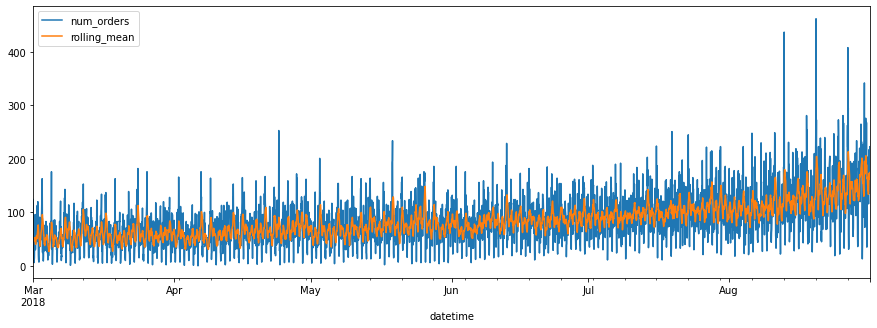

In [5]:
data = df.copy()

data['rolling_mean'] = data.rolling(10).mean() 

data.plot(figsize=(15, 5))
plt.show()

Отсюда мы видим, что начиная с мая-июня увеличивается число заказов такси. Это легко объяснить тем, что в данный период начинается сезон летних отпусков.

Далее разложим наш временной ряд на тренд и сезонную компоненту.

**За исследуемый период (полгода)**

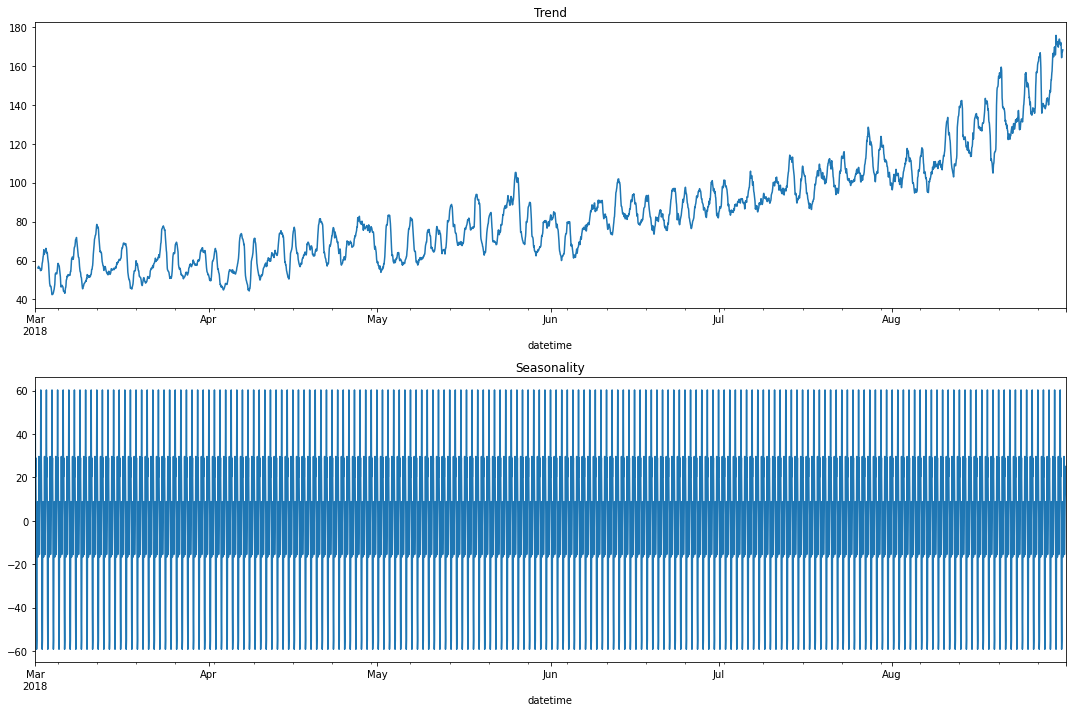

In [6]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

**За месяц**

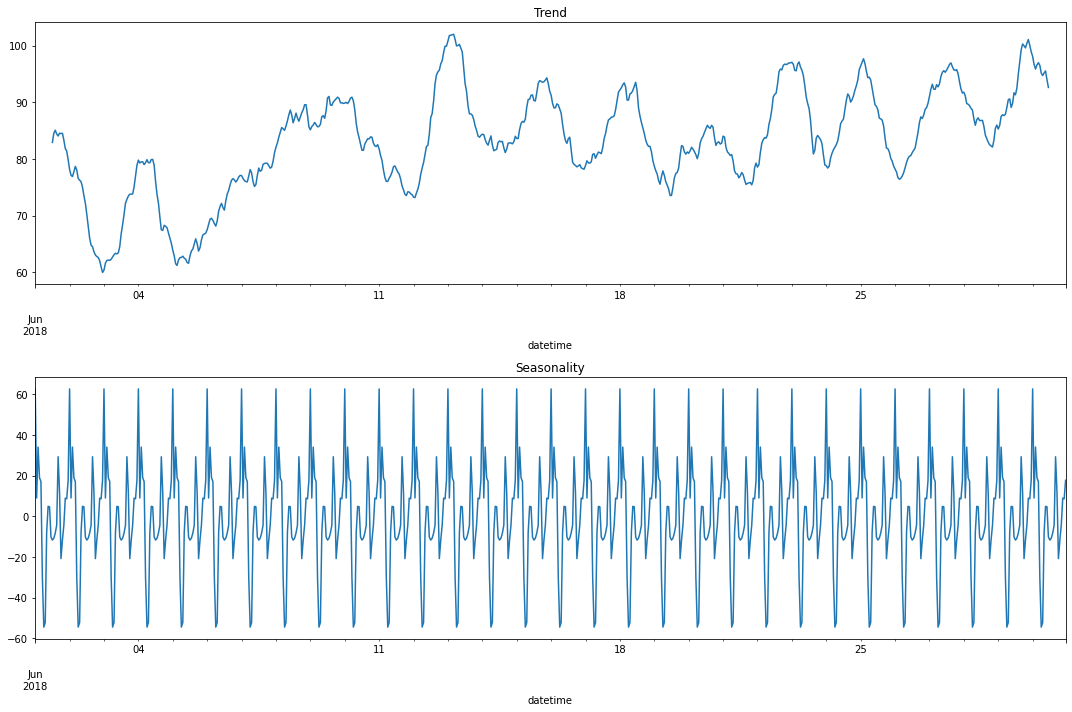

In [7]:
decomposed = seasonal_decompose(df['2018-06-01':'2018-06-30'])

plt.figure(figsize=(15, 10))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

**За неделю (пн-вс)**

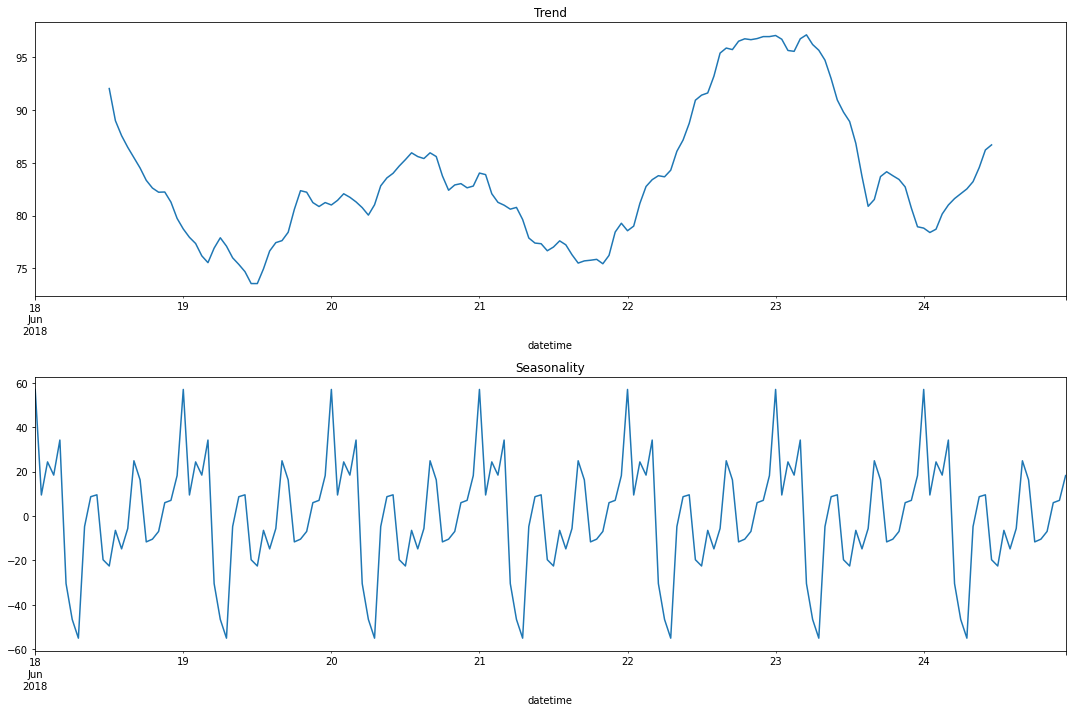

In [8]:
decomposed = seasonal_decompose(df['2018-06-18':'2018-06-24'])

plt.figure(figsize=(15, 10))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

**Вывод**

Таким образом, проведя временной анализ временного ряда, изучив сезонность и тренды за разные периодны время, можно сделать следующие выводы: 

- Можно утверждать, что на протяжении всего изучаемого периода отмечается увеличение числа заказа такси с каждым месяцем. Также здесь можно отметить, что более динаминчое увеличение числа заказов такси начинается в начале лета. Этот факт объясняется тем, что на данный период приходится сезон летних отпусков, и люди чаще вылетяют в другие страны с целью отдыха.
- Проанализировав недельный период, здесь также стоит отметить, что увеличение заказов такси приходится с пятницы по воскресенье. К числу вылетающих/прилетающих на отдых добавляются категория пассажиров, которые в выходные дни захотели провести, например, в другом городе или просто навестить родных, проживающих в другом населенном пункте.
- Тажке прослеживается сезонность в течение дня. Наибольше количество заказов такси приходится на вечернее время суток. Начиная с 1-2ч ночи происходит резкий спад спроса на такси. Далее после полудня спрос начинает увеличиваться.

## Обучение

Для начала подготовим наши данные для дальнейшего обучения: создадим признаки, выделим целевой признак и остальные признаки, разобьем данные на обучающую и тестовую выборки.

In [9]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour  
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
train, test = train_test_split(df, test_size=0.1, shuffle=False, random_state=12345)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

Данные готовы к обучению.
Обучение будем проводить с помощью RandomForestRegressor и с помощью модели градиентного бустинга LightGBM.

**RandomForestRegressor**

In [13]:
tscv = TimeSeriesSplit(n_splits=5)

model_ran_for_reg = RandomForestRegressor(random_state=12345)
parametrs_ran_for_reg = { 'max_depth': range (3, 8),
                          'n_estimators': range (1, 33, 8)}
grid_ran_for_reg = GridSearchCV(model_ran_for_reg, 
                                parametrs_ran_for_reg, 
                                scoring='neg_mean_squared_error', 
                                cv=tscv)

In [14]:
%%time
grid_ran_for_reg.fit(features_train, target_train)

print ('best_params_' ,grid_ran_for_reg.best_params_)

best_params_ {'max_depth': 7, 'n_estimators': 25}
CPU times: user 12.3 s, sys: 46.5 ms, total: 12.4 s
Wall time: 12.4 s


In [15]:
%%time
model_ran_for_reg = RandomForestRegressor(max_depth=7, n_estimators=25, random_state=12345)
model_ran_for_reg.fit(features_train, target_train)

CPU times: user 541 ms, sys: 7.91 ms, total: 549 ms
Wall time: 552 ms


RandomForestRegressor(max_depth=7, n_estimators=25, random_state=12345)

**LightGBM**

In [17]:
model_lightGBM = LGBMRegressor(random_state=12345)
parametrs_lightGBM = { 'max_depth': range (5, 9),
                       'n_estimators': range (10, 40, 10)}

grid_lightGBM = GridSearchCV(model_lightGBM, 
                                parametrs_lightGBM, 
                                scoring='neg_mean_squared_error', 
                                cv=tscv)

In [18]:
%%time

grid_lightGBM.fit(features_train, target_train)

print ('best_params_' ,grid_lightGBM.best_params_)

best_params_ {'max_depth': 8, 'n_estimators': 30}
CPU times: user 29min 23s, sys: 16.4 s, total: 29min 39s
Wall time: 29min 47s


In [19]:
%%time

model_lightGBM = LGBMRegressor(random_state=12345, max_depth=8, n_estimators=30)
model_lightGBM.fit(features_train, target_train)

CPU times: user 1min 22s, sys: 714 ms, total: 1min 23s
Wall time: 1min 23s


LGBMRegressor(max_depth=8, n_estimators=30, random_state=12345)

Подобрали оптимальные гиперпарметры для молелей. Далее можно приступать к прогнозированию и оценке качества моделей. 

## Тестирование

**RandomForestRegressor**

In [20]:
%%time

predictions_ran_for_reg = model_ran_for_reg.predict(features_test)
print('RMSE линейной регресси:', mean_squared_error(target_test, predictions_ran_for_reg)**0.5)

RMSE линейной регресси: 47.14922356160602
CPU times: user 7.23 ms, sys: 0 ns, total: 7.23 ms
Wall time: 6.31 ms


**LightGBM**

In [21]:
%%time

predictions_lightGBM = model_lightGBM.predict(features_test)
print('RMSE LightGBM:', mean_squared_error(target_test, predictions_lightGBM)**0.5)

RMSE LightGBM: 46.96667348706151
CPU times: user 38.4 ms, sys: 0 ns, total: 38.4 ms
Wall time: 13.4 ms


**Вывод**

Был проанализирован датасет с инфорамцией о заказах такси в аэропорту за период март 2018 г. - август 2018г. Просемплировали нашу выборку по одному часу и далее провели анализ данных, используя разложение временного ряда на тренды и сезонности. Далее подготовили наши данные к обучению. Для обучения выбрали модель RandomForestRegressor и модель градиентного бустинга LightGBM. В итоге, на тестовой выборки лучший результат качетсва модели RMSE показала модель градиентного бустинга LightGBM. RMSE составил 46.97.

In [29]:
frame = {'Target':target_test, 'Prediction':predictions_lightGBM}
target_pred = pd.DataFrame(frame)

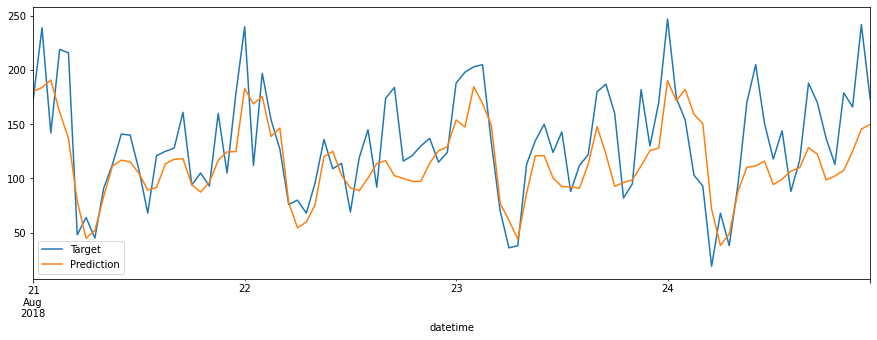

In [30]:
target_pred['2018-08-21':'2018-08-24'].plot(figsize=(15, 5))
plt.show()

По данному графику видно, что примерно до 12 часов дня модель хорошо прогнозирует. А вот после 12 есть отклонения. Наша модель прогнозирует увеличение числа заказов более плавно, чем есть на самом деле. В фактическим данных мы видим некие "скачки", а модель их сглаживает. 